# Diabetes EDA Notebook

## All of our necessary imports go here, with standard aliases.

In [1]:
import pandas as pd
import numpy as np
from numpy import std
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns

## Local (specific) variables can be defined here.

In [2]:
path_to_data: str = '../data/raw/diabetes.csv'
remove_zeros_from_these_columns: list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

## Production functions defined here.

### Data Handling

In [29]:
def get_data(path_to_data: str) -> pd.DataFrame:
    """
    Takes in a relative filepath (str) and returns a Pandas dataframe.
    Expand Docstring here.
    """
    
    df = pd.read_csv(path_to_data) #add params here
    return df


def drop_observations(dataframe, index_to_drop: list) -> pd.DataFrame:
    # Incomplete.
    return None


def remove_outliers(series, Z: float) -> list:
    """
    Takes a pandas Series and flags indices with a Z score out of the std_val range. 
    Returns a list of index values to drop.
    """
    
    outlier_index = []
    
    mean = mean(series)
    std_dev = std(series)
    bound = std_dev * Z
    
    
    for observation in series:
        if abs(series[observation] - mean) > bound:
            outlier_index.append(observation)
        else:
            continue
    return outlier_index

### Visualization

In [27]:
def generate_heatmap(dataframe, vmin=-1, vmax=1, cmap='rocket_r', annot=True) -> None:
    # Takes a dataframe and some optional variables. Displays a correlation matrix heatmap. Returns None.
    
    matrix = dataframe.corr()
    sns.heatmap(matrix, vmin=-1, vmax=1, cmap='rocket_r', annot=True)
    plt.show()
    return None

def show_dist_figs(dataframe, column_name: str, num_bins=20) -> None:
    # Takes a pandas df and a certain column and displays a boxplot and histogram. Returns None.
    
    sns.boxplot(data=df[column_name], orient='h').set(xlabel=column_name)
    plt.show()
    sns.histplot(data=df[column_name], kde=True, bins = num_bins)
    plt.show()
    return None

def generate_scatterplot(dataframe, x_lab: str, y_lab: str, hue_lab='Outcome') -> None:
    # Takes a dataframe and two feature names as well as an optional hue arg. Displays a scatterplot. Returns None.
    
    sns.scatterplot(data=dataframe, x=x_lab, y=y_lab, hue=hue_lab)
    plt.show()
    return None

In [5]:
df = get_data(path_to_data)

At this point, we can begin cleaning, EDA, and feature engineering. Let's look for:
### Cleaning 
1. Missing values, zeroes, and NaNs.
2. Outliers or values outside of 3 sigma.
3. Type errors, encoding errors, etc.
4. Duplicates, if any.

### EDA
1. Correlational matrix (which features best predict the label?).
2. Is there skew or kurtosis in the feature distribution?
3. Understanding features holistically (what does 'skin thickness' or 'pedigree' mean?).

### Feature Engineering
1. Imputation of missing values, zeroes, NaNs.   
    a. Median method.  
    b. KNN cluster analysis method.
2. Creation of new, derivative features.
    a. Branch the dataset at this point so that one can be used for an ANN and the other for ensemble.
3. Scaling, capping, etc.

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Let's check for encoding errors.

In [34]:
df.dtypes

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

### Of all the float64 columns, only BMI and DPF are true float values. Not sure whether to convert to int64 for sake of performance or just leave it alone. Should definitely encode Outcome column to type Boolean though.

### Let's introduce some cleaning functions.

In [7]:
def zeroes_exist(dataframe) -> bool:
    # Check if zeroes in either flt or int form exist. Prints type of zero and returns boolean.
    
    if 0 in dataframe.values or 0.0 in dataframe.values:
        if 0 in dataframe.values:
            print("Int-type 0 found in dataset")
            return True
        else:
            print("Float-type 0.0 found in dataset")
            return True
    else:
        return False

In [8]:
def NaNs_exist(dataframe) -> bool:
    # Takes in a dataframe, returns True if NaNs are present, False otherwise.
    
    return dataframe.isnull().values.any()

In [9]:
def count_zeroes(dataframe, column_header) -> int:
    
    # Takes in a dataframe and a column name and returns number of zeroes (float and int)
    if 0 in dataframe[column_header].values: # If it has no zeroes
        count = dataframe[column_header].value_counts()[0]
        return count
    else:
        return 0
        
        

In [10]:
def summarize_zeroes(dataframe) -> dict:
    # Takes in a dataframe and returns a dict that maps feature names to number of missing values.
    
    zeroes_dict = {}
    for header in dataframe.columns:
        num_zeroes = count_zeroes(dataframe, header)
        zeroes_dict[header] = num_zeroes
    return zeroes_dict

def plot_zeroes(dict_of_zeros):
    plt.bar(dict_of_zeros.keys(), dict_of_zeros.values())
    plt.xticks(rotation='vertical')
    plt.show()

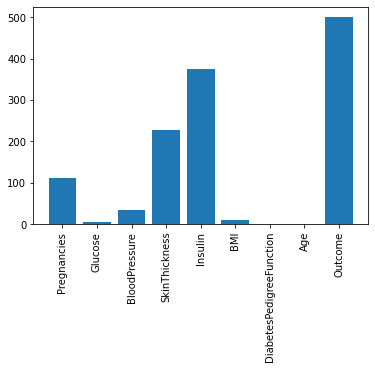

In [11]:
plot_zeroes(summarize_zeroes(df))

#### It's clear that there are zeros present in Glucose, Blood Pressure, Skin Thickness, Insulin, and BMI that should not be there. Let's begin by replacing those zeros with NumPy NaNs, that way Pandas understands that they are missing, not actual zero measurements.

In [12]:
def zeros_to_nans(dataframe,column_list) -> pd.DataFrame:
    dataframe[column_list] = dataframe[column_list].replace({'0':np.nan, 0:np.nan})
    return dataframe

df = zeros_to_nans(df, remove_zeros_from_these_columns)

#### Check that worked...

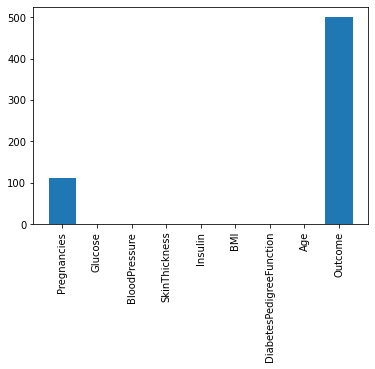

In [13]:
plot_zeroes(summarize_zeroes(df))

#### Time to look for outliers.

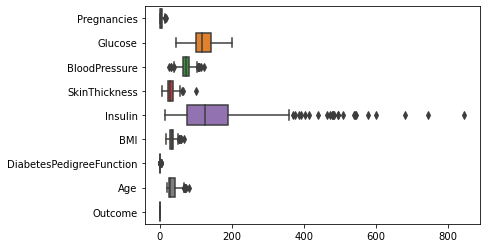

In [14]:
overall_box = sns.boxplot(data=df, orient='h')

#### Okay, let's step through this and make some design decisions.

### Pregnancies

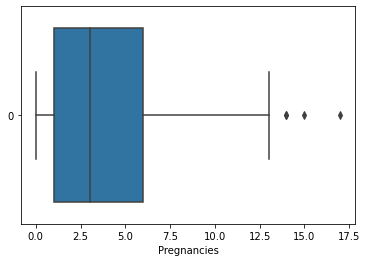

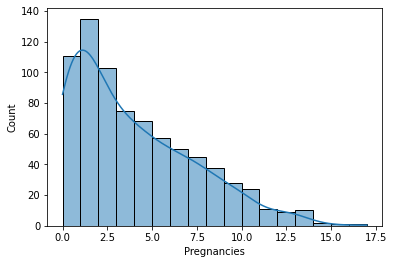

In [15]:
show_dist_figs(df,'Pregnancies',17)

#### This is an almost linear distribution, so in this case, we have a small number (3) of outliers that can likely be excluded. The edge of the whisker is at 1.5 sigma.

### Glucose

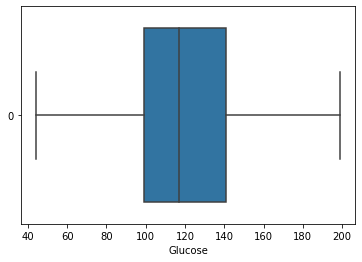

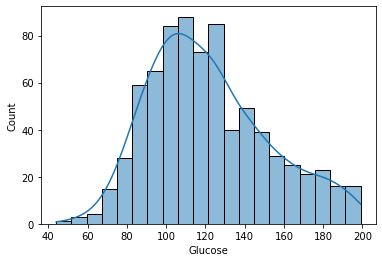

In [16]:
show_dist_figs(df,'Glucose')

#### This is exactly what would be expected, a somewhat normal distribution with a hump on the right for the diabetic set. No outliers found, I think this data shouldn't be trimmed of outliers.

### Blood Pressure

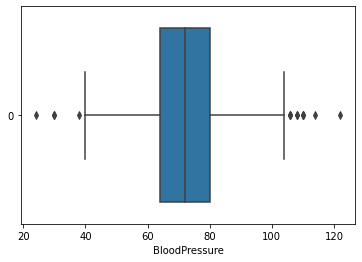

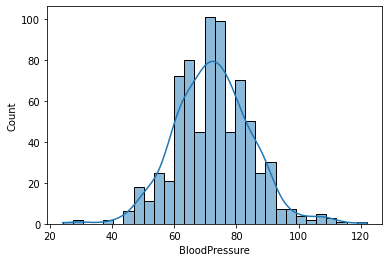

In [17]:
show_dist_figs(df,'BloodPressure',30)

### Skin Thickness

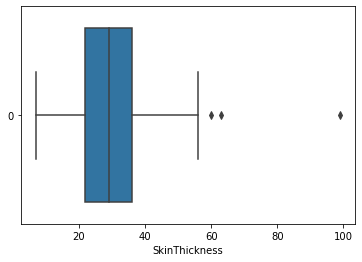

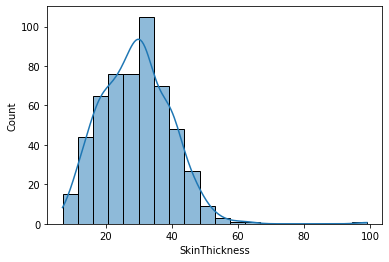

In [18]:
show_dist_figs(df,'SkinThickness')

#### Right-skew is evident here, very long tail. Outliers here are obvious.

### Insulin

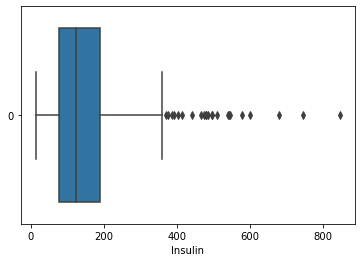

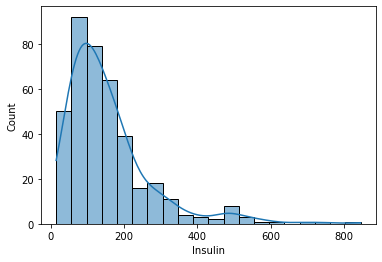

In [19]:
show_dist_figs(df,'Insulin')

#### OK, another right-skewed distribution. However, from medical principles, insulin is going to be predictive of diabetic status. If we do a scatterplot (multivariate outlier analysis) we should see a predictive effect:

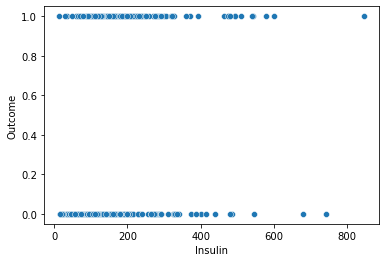

In [20]:
sns.scatterplot(data=df, x='Insulin', y='Outcome')
plt.show()

#### There seems to be a predictive cluster between 450 and 600 ng/dL insulin. However, it seems like we can set an outlier cut-off past 600.

### BMI

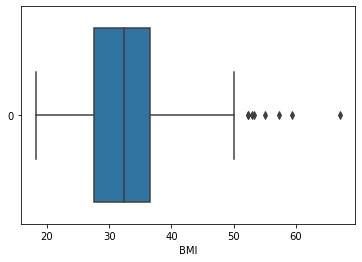

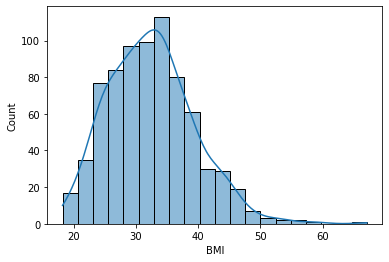

In [21]:
show_dist_figs(df,'BMI')

#### Right skew continues, and it seems as if Insulin, BMI, Skin Thickness can all be superimposed on each other with minimal loss. BMI being a function of Skin Thickness is totally unsurprising, but the link between Insulin (a molecule in the bloodstream) and BMI (a phenotype) is both scientifically and statistically interesting.

### Diabetes Pedigree Function

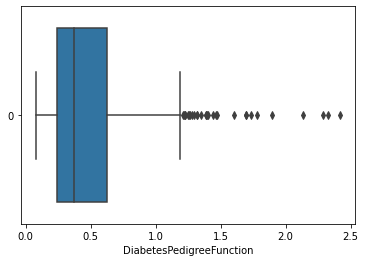

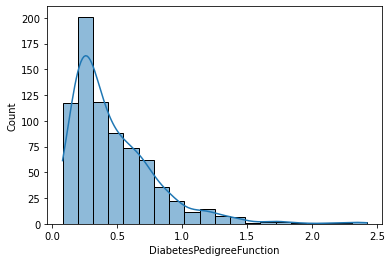

In [22]:
show_dist_figs(df,'DiabetesPedigreeFunction')

#### DPF indicates family history of diabetes. It's a cumulative score, 0.5 for full sibling or parent, 0.25 half sibling, grandparent, aunt, or uncle, 0.125 half aunt, half uncle, or first cousin. Higher DPF scores should correlate with Outcome, so trimming outliers might not be a good idea.

### Age

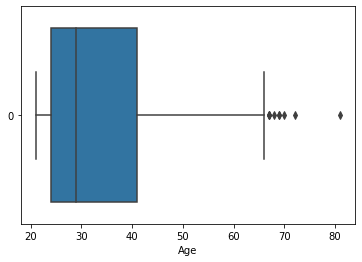

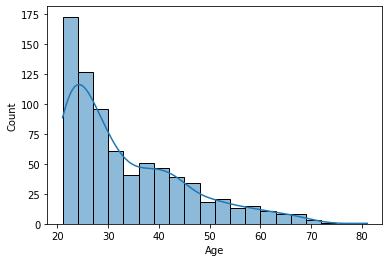

In [23]:
show_dist_figs(df, 'Age')

#### Doesn't make sense to make a model that doesn't work on elderly people or young people so no outlier removal here.

### Summary of Outliers
1. Pregnancies  
    **a. Z=1.5**
2. Glucose  
    b. No trim.  
3. BloodPressure  
    **c. Z=2**
4. SkinThickness  
   **d. Z=2**
5. Insulin  
    e. No trim.
6. BMI  
   **f. Z=2**
7. Pedigree  
    g. No trim.
8. Age  
    h. No trim.

# Feature Engineering

### Correlational Matrix

In [24]:
predictors = df.corr()['Outcome'].sort_values(ascending=False)
print(predictors)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64


#### We can see that the top 3 most influential features are Glucose, BMI, and Insulin in that order.

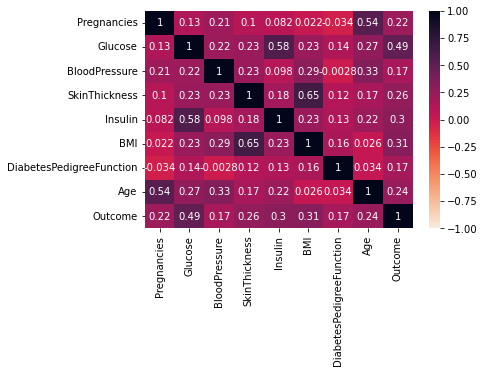

In [28]:
generate_heatmap(df)

#### The most interesting correlation is between Insulin and Glucose. Let's scatter that.

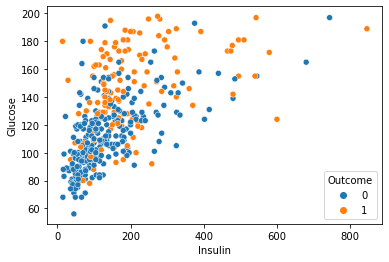

In [26]:
generate_scatterplot(df, 'Insulin', 'Glucose')